In [105]:
import bovespa
import pandas as pd
import csv
import fnmatch
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from os import listdir, path
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [141]:
class Indicator:
    @classmethod
    def bbands(self, df, price_attr, n, nstd, **kwargs):
        MA = pd.Series(df[price_attr].rolling(window=n).mean())
        MSD = pd.Series(df[price_attr].rolling(window=n).std())
        
        Base = pd.Series(MA, name = kwargs["base_name"])
        Upper = pd.Series(MA + MSD * nstd, name = kwargs["upper_name"])
        Lower = pd.Series(MA - MSD * nstd, name = kwargs["lower_name"])
        Trend = pd.Series(0, index = Lower.index, name = kwargs["trend_name"])
        
        for idx, dateidx in enumerate(Upper.index):
            if idx >= n:
                if (df[price_attr][idx] > Upper[idx-1]):
                    Trend[idx] = 1
                if (df[price_attr][idx] < Lower[idx-1]):
                    Trend[idx] = -1                
                if (Trend[idx] == 1) and (Lower[idx] < Lower[idx-1]):
                    Lower[idx] = Lower[idx-1]
                elif (Trend[idx] == -1) and (Upper[idx] > Upper[idx-1]):
                    Upper[idx] = Upper[idx-1]
        return pd.concat([Upper, Base, Lower, Trend], join='outer', axis=1)

class Parser:
    def __init__(self, inpt, output=None):
        self.input = inpt
        self.output = output

    @classmethod
    def convert_record_to_dict(self, query):
        for rec in query:
            yield rec.info

    def get_query(self):
        bf = bovespa.File(self.input)
        return bf.query()

    def get_dataframe(self):
        return pd.DataFrame(self.convert_record_to_dict(self.get_query()))
    
class Select:
    def __init__(self, option=None, dropdown=None):
        self.option = option
        self.dropdown = dropdown
        
    def get_dropdown(self, options, description="Option:"):
        if not self.dropdown:
            w = widgets.Dropdown(options=options,description=description,value=options[0])
            w.observe(self.on_change)
            self.dropdown = w
            self.option = w.value
        
        return self.dropdown
    
    def on_change(self, change):      
        if change.name == "value" and change.type == "change":
            self.option = change.new    
            
class Reader(Select):
    @classmethod
    def get_files(self, where, regex):
        return [name for name in listdir(where) if re.compile(fnmatch.translate(regex), re.IGNORECASE).match(name)]

In [3]:
directory = "../data"
file = Select()
display(file.get_dropdown(Reader.get_files(directory, "*.txt"), "Arquivo:"))

Dropdown(description='Arquivo:', options=('COTAHIST_A2017.TXT',), value='COTAHIST_A2017.TXT')

In [23]:
p = Parser(path.join(directory, file.option))
d = p.get_dataframe()
codes = d.CODNEG

In [69]:
options = codes[
    np.logical_and(
        ~codes.str.contains("\d\w|\d\d"),
        codes.str.contains("\d")
    )].sort_values().unique()

stock1 = Select()
stock2 = Select()

display(stock1.get_dropdown(options, "Stock 1:"))
display(stock2.get_dropdown(options, "Stock 2:"))

Dropdown(description='Stock 1:', options=('AALR3', 'ABCB2', 'ABCB4', 'ABEV3', 'ABEVA1', 'ABEVA3', 'ABEVA7', 'A…

Dropdown(description='Stock 2:', options=('AALR3', 'ABCB2', 'ABCB4', 'ABEV3', 'ABEVA1', 'ABEVA3', 'ABEVA7', 'A…

In [193]:
d_stock1 = d[codes == stock1.option]
d_stock1.index = range(len(d_stock1))
d_stock2 = d[codes == stock2.option]
d_stock2.index = range(len(d_stock2))

formula = f'{stock1.option}/{stock2.option}'

df = pd.DataFrame()
df['DATE'] = d_stock1.DATPRG
df['FORMULA'] = formula
df['RATIO'] = d_stock1.PREULT/d_stock2.PREULT
df[stock1.option] = d_stock1.PREULT
df[stock2.option] = d_stock2.PREULT

bbands = Indicator.bbands(
    df, "RATIO", 21, 2, 
    upper_name="BBANDS_UPPER",
    base_name="BBANDS_BASE",
    lower_name="BBANDS_LOWER",
    trend_name="BBANDS_TREND"
)

df = pd.merge(df, bbands, left_index=True, right_index=True)

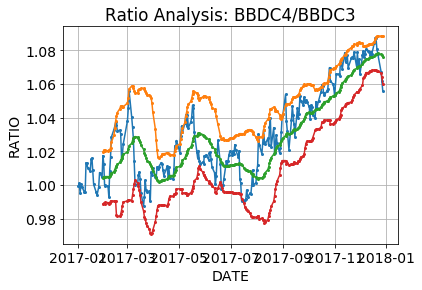

In [199]:
fig, ax = plt.subplots()
ax.plot(df["DATE"], df['RATIO'], marker='o', markersize=2)
ax.plot(df["DATE"], df['BBANDS_UPPER'], marker='o', markersize=2)
ax.plot(df["DATE"], df['BBANDS_BASE'], marker='o', markersize=2)
ax.plot(df["DATE"], df['BBANDS_LOWER'], marker='o', markersize=2)

ax.set(
    xlabel="DATE", 
    ylabel="RATIO",
    title=("Ratio Analysis: " + formula)
)

ax.grid()
fig.savefig("test.png")

plt.show()